# Municipality Analysis

In [1]:
#Cargando librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('nutritive.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

/home/localhost/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.property_type.unique()

array(['Casa', 'Otro', 'Lote', 'Finca', 'Oficina', 'Apartamento',
       'Parqueadero', 'Local comercial', 'Depósito', nan], dtype=object)

In [4]:
import re
from unicodedata import normalize
def cleanText(inputString):
    return (re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", inputString), 0, re.I
    )).lower()

def clean_l3(row):
    row.l3 = cleanText(row.l3)
    return row



## Sell and Rent Counting

In [5]:
df = df.where(df['operation_type'] == 'Venta').dropna(subset=['operation_type'])
df = df.apply(lambda x: clean_l3(x), axis=1)
df.shape

(613054, 25)

In [6]:
df_train = df.copy()
    
df_train = df_train[df_train['price']<df_train['price'].quantile(0.99)]
df_train = df_train[df_train['price'] > df_train['price'].quantile(0.1)]
df_train = df_train[df_train['surface_total'] > 0]
df_train = df_train[~np.isnan(df_train['price']) & df_train['price'] > 0]
df_train = df_train[df_train['surface_total'] > 0]

df_train['price'] = np.log(df_train['price'])

In [7]:
df_final = df_train.copy()

In [8]:
n = 10 #First n most frequent municipalities
series = df_train['l3'].value_counts()[:n]
municipalities = list(series.index)
freq = list(series)

In [9]:
df_balanced = pd.DataFrame(columns=list(df_train.columns))

In [10]:
#To make undersampling
n_under = min(freq) #Undersampling min number
df_final = df_train[df_train['l3'].isin(municipalities)]

for x in municipalities:
    temp_df = df_final[df_final['l3'] == x].sample(n = n_under, random_state=4)
    df_balanced = pd.concat([df_balanced, temp_df], ignore_index=True)
    

In [11]:
df_balanced.drop(columns=['id',"ad_type",'start_date', 'start_date','created_on','end_date',
                 'l1','l2', 'l3', 'l4','l6', 'l5', 
                 'rooms', 'price_period', 'surface_covered',
                 'operation_type','currency', 'title', 'description'], inplace=True)

In [12]:
df_train = df_balanced.copy()

## Machine Learning - Initial Model

In [13]:
X_df = df_train.drop('price', axis=1).copy()
Y_df = df_train['price'].copy()

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train_or, X_test_or, Y_train_or, Y_test_or = train_test_split(
    X_df, Y_df, test_size=0.2, random_state=5000)

In [16]:
# Para eliminar SettingWithCopyWarning

X_train = X_train_or.copy()
X_test = X_test_or.copy()
Y_train = Y_train_or.copy()
Y_test = Y_test_or.copy()

In [17]:
from sklearn.preprocessing import (PowerTransformer, StandardScaler, 
                                   MinMaxScaler, LabelEncoder, OneHotEncoder)

### Power Transformer Labels (Box-Cox)

Normalize and reduce scale

In [18]:
box_cox = PowerTransformer(method='box-cox') # Box-Cox object instance
box_cox.fit(X_train["surface_total"].values.reshape(-1,1)) # Box-Cox, array 2 dimensions
X_train.loc[:,"surface_total"] = box_cox.transform(X_train["surface_total"].values.reshape(-1,1)) # Transformamos el array
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,property_type
64916,7.100000,-73.116997,5.0,2.0,0.190543,Apartamento
20641,11.023675,-74.860947,NaN,3.0,-0.092228,Casa
29793,5.072902,-75.523653,4.0,2.0,0.861274,Casa
45451,7.893000,-72.488000,2.0,2.0,-0.714284,Apartamento
62604,NaN,NaN,4.0,4.0,0.768529,Apartamento


### Standard Scaler
El Standard Scaler sirve para centrar una distribución en 0 y que tenga desviación estándar unitaria.

 $$\mathbf{Z} = \frac{\mathbf{X} - \mathbf{\mu}}{\mathbf{\sigma}}$$


In [19]:
# Categorical Class

print("Classes: ", X_train['property_type'].unique())
X_train.head()

Classes:  ['Apartamento' 'Casa' 'Lote' 'Finca' 'Otro' 'Parqueadero' 'Oficina'
 'Local comercial' 'Depósito']


,lat,lon,bedrooms,bathrooms,surface_total,property_type
64916,7.100000,-73.116997,5.0,2.0,0.190543,Apartamento
20641,11.023675,-74.860947,NaN,3.0,-0.092228,Casa
29793,5.072902,-75.523653,4.0,2.0,0.861274,Casa
45451,7.893000,-72.488000,2.0,2.0,-0.714284,Apartamento
62604,NaN,NaN,4.0,4.0,0.768529,Apartamento


In [20]:
le_proper_type = LabelEncoder()
le_proper_type.fit(X_train['property_type'])
X_train['property_type'] = le_proper_type.transform(X_train['property_type'])

In [21]:
ohe_proper_type = OneHotEncoder()
ohe_proper_type.fit(X_train["property_type"].values[:,None])
out = ohe_proper_type.transform(X_train["property_type"].values[:,None]) 
out_array = out.toarray()
ohe_cols_op = []
for category in ohe_proper_type.categories_[0]:
    current_class = le_proper_type.classes_[int(category)]
    col_add = "op_" + current_class
    ohe_cols_op.append(col_add)
    X_train[col_add] = out_array[:,int(category)]

X_train = X_train.drop("property_type", axis =1)

### Tratamiento de datos faltantes o NaN

In [22]:
from sklearn.impute import SimpleImputer

In [23]:
# Using Simple Imputer

si_bedrooms = SimpleImputer(strategy='mean')
si_bedrooms.fit(X_train["bedrooms"].values[:,None])
X_train["bedrooms"] = si_bedrooms.transform(X_train["bedrooms"].values[:,None])

si_lat = SimpleImputer(strategy='mean')
si_lat.fit(X_train["lat"].values[:,None])
X_train["lat"] = si_lat.transform(X_train["lat"].values[:,None])

si_lon = SimpleImputer(strategy='mean')
si_lon.fit(X_train["lon"].values[:,None])
X_train["lon"] = si_lon.transform(X_train["lon"].values[:,None])

si_bath = SimpleImputer(strategy='mean')
si_bath.fit(X_train["bathrooms"].values[:,None])
X_train["bathrooms"] = si_bath.transform(X_train["bathrooms"].values[:,None])

In [24]:
#Otras transformaciones
cols2scale = ['bedrooms', 'bathrooms']
se_cols2scale = StandardScaler()
se_cols2scale.fit(X_train[cols2scale])
X_train[cols2scale] = se_cols2scale.transform(X_train[cols2scale])
X_train.head()

,lat,lon,bedrooms,bathrooms,surface_total,op_Apartamento,op_Casa,op_Depósito,op_Finca,op_Local comercial,op_Lote,op_Oficina,op_Otro,op_Parqueadero
64916,7.100000,-73.116997,1.013676e+00,-0.605380,0.190543,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20641,11.023675,-74.860947,5.776931e-16,0.134606,-0.092228,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29793,5.072902,-75.523653,3.632511e-01,-0.605380,0.861274,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45451,7.893000,-72.488000,-9.375981e-01,-0.605380,-0.714284,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62604,6.747057,-74.861314,3.632511e-01,0.874593,0.768529,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
X_test['surface_total'] = box_cox.transform(X_test['surface_total'].values[:,None])


In [26]:
X_test['property_type'] = le_proper_type.transform(X_test['property_type'])

In [27]:
temp_test = ohe_proper_type.transform(X_test["property_type"].values[:,None]).toarray()
for idx, col in enumerate(ohe_cols_op):
    X_test[col] = temp_test[:,idx]

X_test = X_test.drop("property_type", axis=1)

In [28]:
X_test['bedrooms'] = si_bedrooms.transform(X_test["bedrooms"].values[:,None])
X_test['lat'] = si_lat.transform(X_test['lat'].values[:, None])
X_test['lon'] = si_lon.transform(X_test['lon'].values[:, None])
X_test['bathrooms'] = si_bath.transform(X_test['bathrooms'].values[:,None])

In [29]:
X_test[cols2scale] = se_cols2scale.transform(X_test[cols2scale])

In [30]:
assert (X_test.columns.values == X_train.columns.values).all()

In [31]:
X_test

,lat,lon,bedrooms,bathrooms,surface_total,op_Apartamento,op_Casa,op_Depósito,op_Finca,op_Local comercial,op_Lote,op_Oficina,op_Otro,op_Parqueadero
25116,3.420000,-76.540000,3.632511e-01,1.346065e-01,-0.476691,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41210,6.173000,-75.581000,-2.871735e-01,-6.053802e-01,-0.195453,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66693,6.747057,-74.861314,-2.871735e-01,8.745932e-01,0.404388,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60839,7.118697,-73.112144,-2.871735e-01,-6.053802e-01,-0.561740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
36843,6.180504,-75.586551,5.776931e-16,-6.053802e-01,0.109448,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44233,7.889000,-72.497002,-2.871735e-01,1.346065e-01,-0.561740,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7948,6.244705,-75.601334,-2.871735e-01,8.745932e-01,0.550659,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47265,7.928000,-72.522000,3.632511e-01,-6.053802e-01,0.038192,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54755,4.805000,-75.694000,-2.871735e-01,1.346065e-01,2.192063,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Using Regression

In [32]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
extra_tree = ExtraTreeRegressor(splitter = "best" ,random_state=1000)
lin_reg = BaggingRegressor(extra_tree, random_state=1000, n_estimators=40)
lin_reg.fit(X_train, Y_train)

BaggingRegressor(base_estimator=ExtraTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   random_state=1000,
                                                   splitter='best'),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=1.0, n_estimators=40, n_jobs=Non

In [33]:
Y_test_estimate = lin_reg.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
rmse = mean_squared_error(Y_test, Y_test_estimate)
print("Root Mean Square Error (RMSE)= {:.2f}".format(rmse))
mae = mean_absolute_error(Y_test, Y_test_estimate)
print("Mean Absolute Error (MAE)= {:.2f}".format(mae))
r2 = r2_score(Y_test, Y_test_estimate)
print("R^2 = {:.3f}".format(r2))

Root Mean Square Error (RMSE)= 0.14
Mean Absolute Error (MAE)= 0.24
R^2 = 0.778


In [34]:
#### cross validation of model

from sklearn.model_selection import  cross_val_score, KFold
kfold = KFold(n_splits=5)
results = cross_val_score(lin_reg, X_train, Y_train, cv=kfold)
print("Efectividad en la validacion : ", results,"\n Promedio de Efectividad predicciones : ", round(np.mean(results), 3))

Efectividad en la validacion :  [0.76281223 0.77082191 0.76522981 0.76891624 0.77139145] 
 Promedio de Efectividad predicciones :  0.768


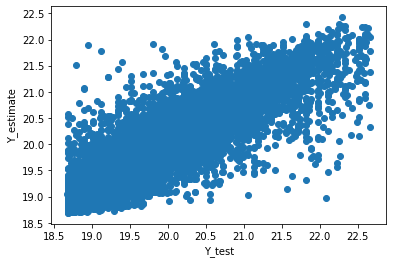

In [35]:
plt.scatter(Y_test, Y_test_estimate)
plt.xlabel("Y_test")
plt.ylabel("Y_estimate")
plt.show()